In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyc-taxi-trip-duration/train.zip
/kaggle/input/nyc-taxi-trip-duration/test.zip
/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip


하루 중 택시 이용량이 어떻게 변하는지 알아보기 위해서는 K-평균 클러스터링을 사용하여 뉴욕을 지역별로 다른 그룹으로 분류하고, 시간에 따라 각 클러스터에서 들어오고 나가는 교통량을 분석할 것입니다. 주거 지역은 저녁에 들어오는 교통량이 더 많을 것이고, 상업 지역은 대부분 낮에 사람들을 유치할 것이며, 활기찬 밤문화를 즐길 수 있는 지역은 밤에 더 많은 교통량을 보일 것입니다.

이 방법은 여행 시간을 예측하는 데 도움이 될 수 있습니다. 우리는 각 지역에서 시간대별로 어떤 목적지가 가능성이 높은지 알 수 있기 때문입니다.

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
import io
import base64
from IPython.display import HTML
from imblearn.under_sampling import RandomUnderSampler
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

nyc-taxi-trip-duration



### Read the data

In [3]:
df = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/train.zip')
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


### Remove rides to and from far away areas

In [4]:
# 뉴욕 맨해튼을 포함하는 일부 지역
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
df = df[(df.pickup_longitude > xlim[0]) & (df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude > xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude > ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude > ylim[0]) & (df.dropoff_latitude < ylim[1])]

In [5]:
# 맨해튼 포함한 일부 지역만 포함되어있는 결과(1458644 -> 1438626)
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


### Plot rides

In [6]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
longitude

[-73.98215484619139,
 -73.98041534423827,
 -73.97902679443358,
 -74.01004028320312,
 -73.97305297851561,
 -73.98285675048828,
 -73.9690170288086,
 -73.96927642822266,
 -73.99948120117188,
 -73.98104858398438,
 -73.98265075683594,
 -73.9915313720703,
 -73.96298217773438,
 -73.95630645751953,
 -73.99219512939453,
 -73.95551300048828,
 -73.99116516113281,
 -73.99425506591797,
 -74.00398254394531,
 -73.98388671875,
 -73.9803695678711,
 -73.9795379638672,
 -73.99586486816406,
 -73.9935531616211,
 -73.95523071289062,
 -73.95658111572266,
 -73.9837646484375,
 -73.95843505859375,
 -73.99421691894531,
 -73.98211669921875,
 -73.97093963623048,
 -73.9982681274414,
 -74.00550079345702,
 -73.99031066894531,
 -74.00899505615233,
 -73.99456024169923,
 -73.9515151977539,
 -73.98806762695312,
 -73.97812652587889,
 -73.97776794433594,
 -73.9885482788086,
 -73.97472381591797,
 -73.97509002685547,
 -73.97647094726561,
 -73.97964477539062,
 -74.01632690429686,
 -73.98513793945312,
 -73.98165893554686,
 -73

In [7]:
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)

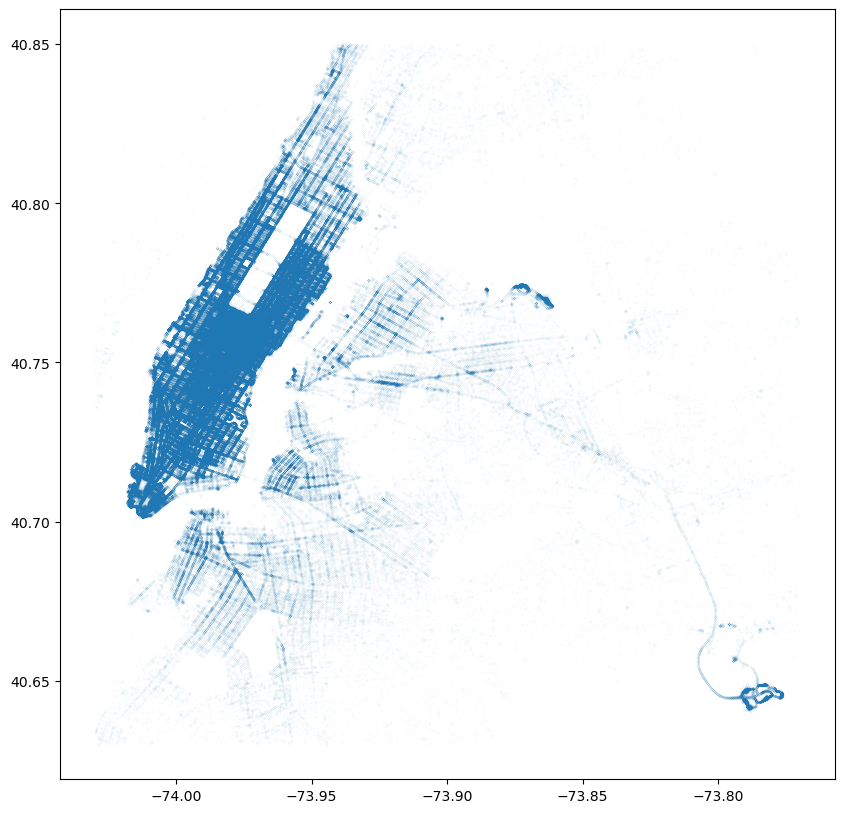

In [8]:
plt.figure(figsize=(10, 10))
plt.plot(longitude, latitude, '.', alpha = 0.4, markersize = 0.05)
plt.show()

In [9]:
#리스트 데이터를 데이터프레임 형식으로 변환
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

In [10]:
loc_df

,longitude,latitude
0,-73.982155,40.767937
1,-73.980415,40.738564
2,-73.979027,40.763939
3,-74.010040,40.719971
4,-73.973053,40.793209
...,...,...
2877247,-73.994911,40.740170
2877248,-73.970184,40.796547
2877249,-74.004433,40.707371
2877250,-73.974632,40.757107


### Cluster
각 택시 승차 및 하차 위치를 기반으로 뉴욕 시를 클러스터링 해보겠습니다.

In [11]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init=10).fit(loc_df)
loc_df['label'] = kmeans.labels_

In [12]:
loc_df.head()

,longitude,latitude,label
0,-73.982155,40.767937,11
1,-73.980415,40.738564,3
2,-73.979027,40.763939,11
3,-74.010040,40.719971,13
4,-73.973053,40.793209,1


In [13]:
#20만개 샘플 무작위 추출
loc_df = loc_df.sample(200000)

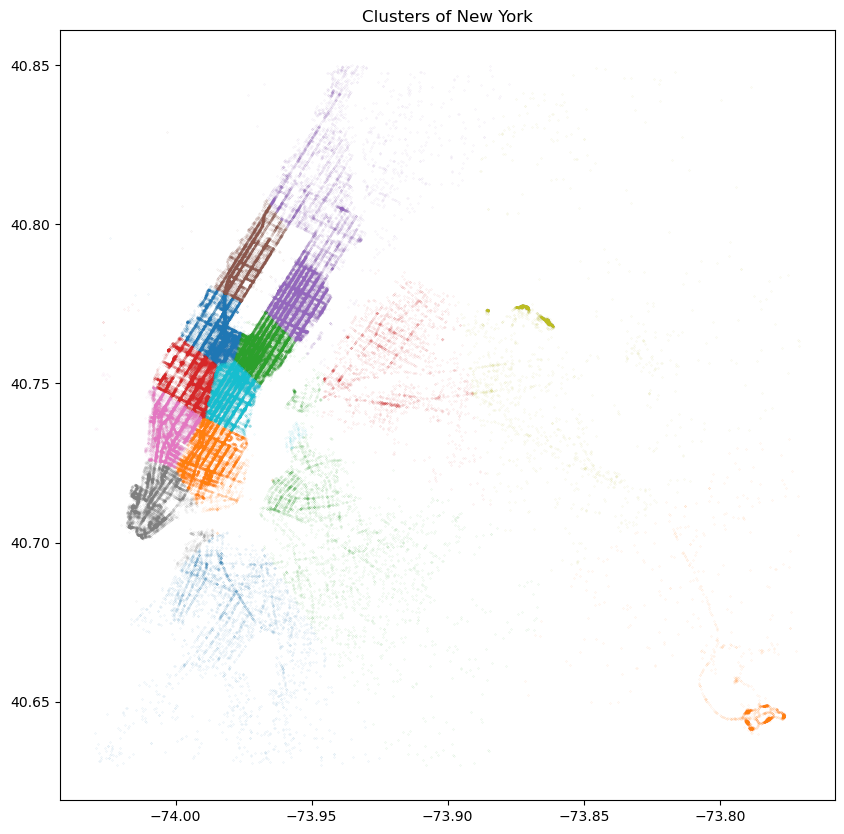

In [14]:
#택시 승하차 위경도 그룹화
plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.3, markersize = 0.3)

plt.title('Clusters of New York')
plt.show()

위에서 본 바와 같이, 클러스터링 결과는 뉴욕의 다른 지역으로 분할된 것과 유사합니다. 그림에서 Upper East Side와 Central Park West가 각각 회색과 분홍색으로 표시되어 있습니다. 서쪽 미드타운은 파란색, 첼시와 웨스트 빌리지는 갈색, 다운타운 지역은 파란색, 이스트 빌리지와 소호는 보라색으로 나타납니다.

JFK 공항과 라구아디아 공항은 각각 자체 클러스터를 갖고 있으며, 퀸즈와 할렘도 마찬가지입니다. 브루클린은 2개의 클러스터로 분할되고, 브롱스는 할렘과 구분하기에 충분히 많은 데이터가 없어 구분되지 않았습니다.

이제 클러스터 중심을 그려봅시다.

(색깔 다르게 출력되어서 결과와 색상이 다르게 매칭될 것)

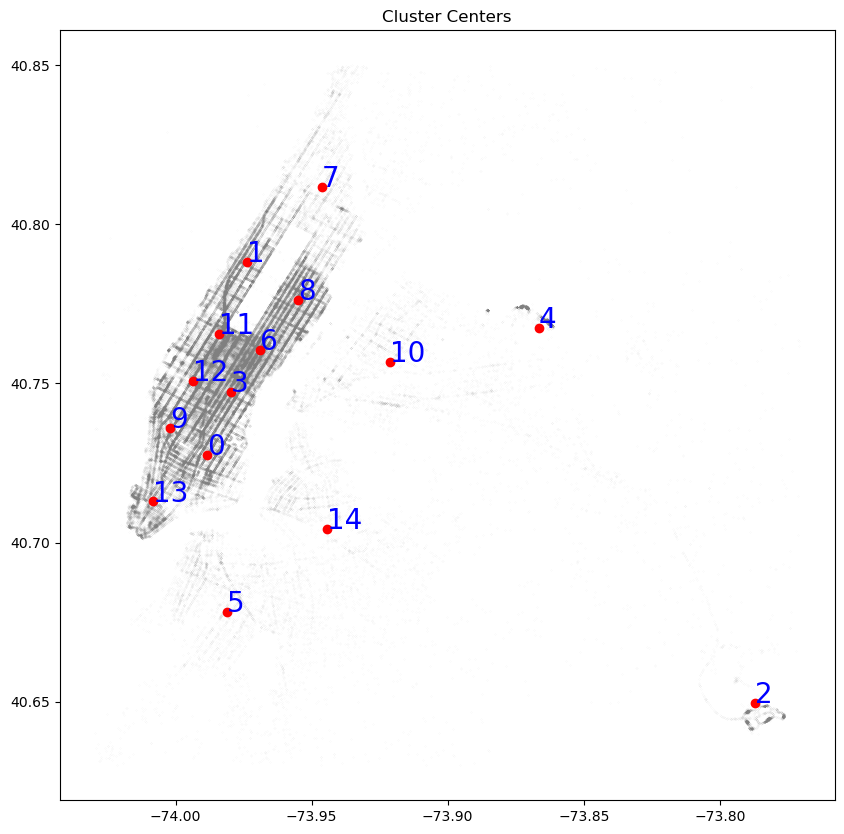

In [15]:
fig,ax = plt.subplots(figsize = (10,10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'b', fontsize = 20)
ax.set_title('Cluster Centers')
plt.show()

In [16]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude','pickup_latitude']])
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude','dropoff_latitude']])
df['pickup_hour'] = df.pickup_datetime.apply(lambda x: parser.parse(x).hour )

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- pickup_latitude
- pickup_longitude
Feature names seen at fit time, yet now missing:
- latitude
- longitude

  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- dropoff_latitude
- dropoff_longitude
Feature names seen at fit time, yet now missing:
- latitude
- longitude

  warnings.warn(message, FutureWarning)


In [17]:
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_cluster,dropoff_cluster,pickup_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,11,6,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,3,9,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,13,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,13,13,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,3,9,13
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,12,1,7
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,8,13,6
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,3,6,15


In [18]:
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:, 0]
clusters['y'] = kmeans.cluster_centers_[:, 1]
clusters['label'] = range(len(clusters))

In [19]:
loc_df = loc_df.sample(5000)

In [20]:
loc_df

,longitude,latitude,label
594284,-73.985672,40.763268,11
1759161,-73.990440,40.724907,0
834638,-73.969246,40.760799,6
1337362,-73.972710,40.759502,6
2267056,-74.008461,40.735279,9
...,...,...,...
990938,-73.975891,40.760689,6
1986386,-73.969009,40.762661,6
8904,-73.998100,40.741009,9
2568443,-73.981415,40.774422,11


### Taxi rides from one cluster to another
다음 애니메이션에서 각각의 화살표는 한 클러스터에서 다른 클러스터로의 승차를 나타냅니다. 화살표의 두께는 해당 시간의 상대적인 여행량에 비례합니다.

In [21]:
def animate(hour):
    ax.clear()
    ax.set_title('Absolute Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10));
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray');
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r');


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = 15*pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.



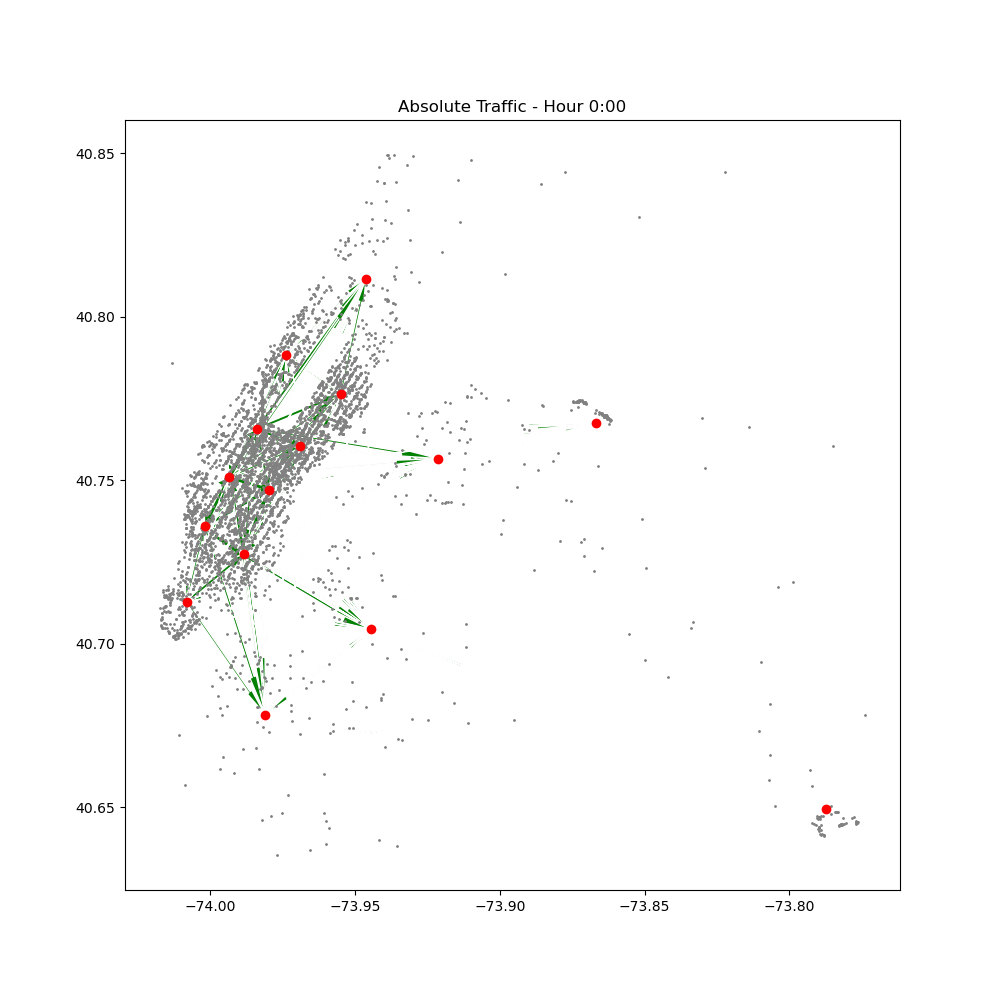

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))


ani = animation.FuncAnimation(fig, animate, sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  



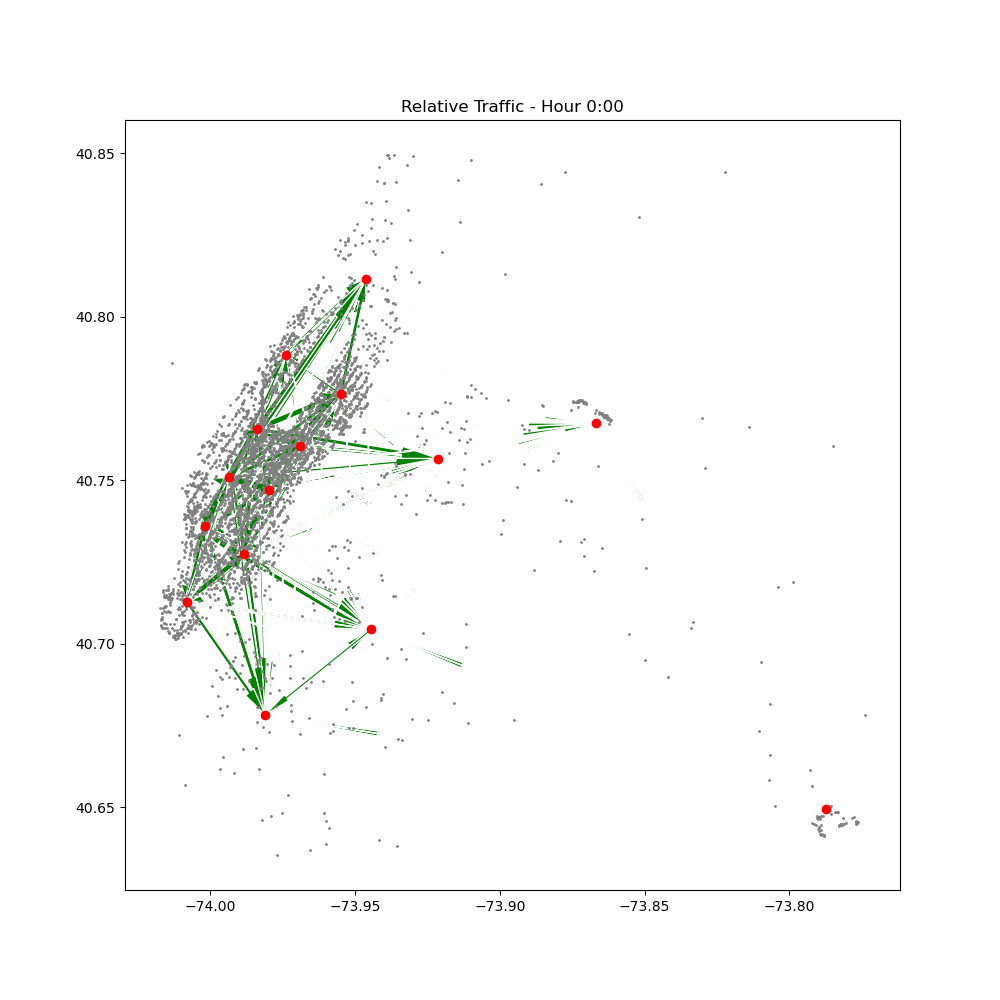

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Relative Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray')
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df[df.pickup_hour == hour]))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

## Neighborhood Analysis

In [24]:
neighborhood = {-74.0019368351: 'Chelsea',-73.837549761: 'Queens',-73.7854240738: 'JFK',-73.9810421975:'Midtown-North-West',-73.9862336241: 'East Village',
                -73.971273324:'Midtown-North-East',-73.9866739677: 'Brooklyn-parkslope',-73.8690098118: 'LaGuardia',-73.9890572967:'Midtown',-74.0081765545: 'Downtown'
                ,-73.9213024854: 'Queens-Astoria',-73.9470256923: 'Harlem',-73.9555565018: 'Uppe East Side',
               -73.9453487097: 'Brooklyn-Williamsburgt',-73.9745967889:'Upper West Side'}

In [25]:
rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df

,Chelsea,Queens,JFK,Midtown-North-West,East Village,Midtown-North-East,Brooklyn-parkslope,LaGuardia,Midtown,Downtown,Queens-Astoria,Harlem,Uppe East Side,Brooklyn-Williamsburgt,Upper West Side


In [48]:
rides_df['name'] = neighborhood.values()

In [49]:
neigh = KNeighborsClassifier(n_neighbors = 1)  #k-최근접 이웃 분류기(K-Nearest Neighbor Classifier)
neigh

KNeighborsClassifier(n_neighbors=1)

- KNeighborsClassifier는 지도학습 알고리즘 중 하나로, 분류 문제에서 가장 널리 사용되는 알고리즘
- 이 알고리즘은 데이터셋에서 가장 가까운 이웃 데이터들의 레이블을 기반으로 새로운 데이터 포인트를 분류
- KNeighborsClassifier는 KNN(K-Nearest Neighbors) 알고리즘을 구현한 것으로, 이웃의 수 K를 지정하여 분류를 수행

KNeighborsClassifier는 이러한 특징 때문에 데이터셋이 작거나 복잡한 패턴이나 결정 경계를 가지고 있는 경우에 적합합니다. 또한, 학습 시간이 짧은 편이기 때문에 빠르게 모델을 만들 수 있습니다. 하지만, 데이터셋이 매우 크거나 특성 공간이 매우 차원이 높은 경우에는 성능이 저하될 수 있습니다. 또한, KNeighborsClassifier는 이상치(outlier)나 잡음(noise)에 민감하기 때문에 이러한 경우에는 다른 알고리즘을 사용하는 것이 좋습니다.

In [50]:
neigh.fit(np.array(list(neighborhood.keys())).reshape(-1, 1), list(neighborhood.values()))

KNeighborsClassifier(n_neighbors=1)

In [51]:
df['pickup_neighborhood'] = neigh.predict(df.pickup_longitude.values.reshape(-1,1))
#df['pickup_neighborhood'] = neigh.predict(df['pickup_longitude'].reshape(-1,1))도 가능
#df.pickup_longitude가 시리즈 객체를 나타내므로, reshape() 함수를 사용할 수 없는 오류 발생했었음

In [29]:
df['dropoff_neighborhood'] = neigh.predict(df.dropoff_longitude.values.reshape(-1,1))

In [39]:
df['dropoff_neighborhood']

0          Midtown-North-East
1                     Chelsea
2                    Downtown
3                    Downtown
4          Midtown-North-East
                  ...        
1458639               Midtown
1458640    Midtown-North-East
1458641               Chelsea
1458642       Upper West Side
1458643    Midtown-North-East
Name: dropoff_neighborhood, Length: 1438626, dtype: object

In [52]:
for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col)]))

In [44]:
## name 칼럼을 만드는 줄 모르고 진행했다가 오류 생겨서 수정했던 코드
rides_df = pd.DataFrame(index=neighborhood.values(), columns=neighborhood.values())

for col in rides_df.columns:
    rides_df[col] = rides_df.index.map(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col)]))

In [53]:
rides_df

,Chelsea,Queens,JFK,Midtown-North-West,East Village,Midtown-North-East,Brooklyn-parkslope,LaGuardia,Midtown,Downtown,Queens-Astoria,Harlem,Uppe East Side,Brooklyn-Williamsburgt,Upper West Side,name
Chelsea,28526,228,950,18989,10622,7657,6141,1497,35963,22084,2119,2209,7998,2317,8742,Chelsea
Queens,27,375,93,55,37,20,5,120,33,24,43,15,43,15,41,Queens
JFK,1887,1221,2779,3578,2116,2351,743,1463,3207,1576,1749,993,2847,1244,2208,JFK
Midtown-North-West,17496,416,2183,30833,13214,27005,6747,4206,35307,10196,2940,4654,22343,3898,23537,Midtown-North-West
East Village,10616,186,1168,13532,5619,8030,2622,2073,16225,5980,1625,1793,7099,1704,9138,East Village
Midtown-North-East,7069,331,1346,24433,7833,25085,3355,2757,15474,4846,2669,6776,37879,5258,19356,Midtown-North-East
Brooklyn-parkslope,6225,116,439,8320,2907,4031,1612,802,8282,3397,1070,1026,3830,1108,4751,Brooklyn-parkslope
LaGuardia,2055,950,793,5189,2958,3550,949,2620,3938,2256,2497,1230,3509,1591,3582,LaGuardia
Midtown,37829,474,1833,41685,17402,18089,8724,3174,43352,22124,4277,4532,17223,4826,22242,Midtown
Downtown,20509,187,869,10457,5776,5202,3295,1626,19725,21964,1095,1258,4792,1231,6167,Downtown


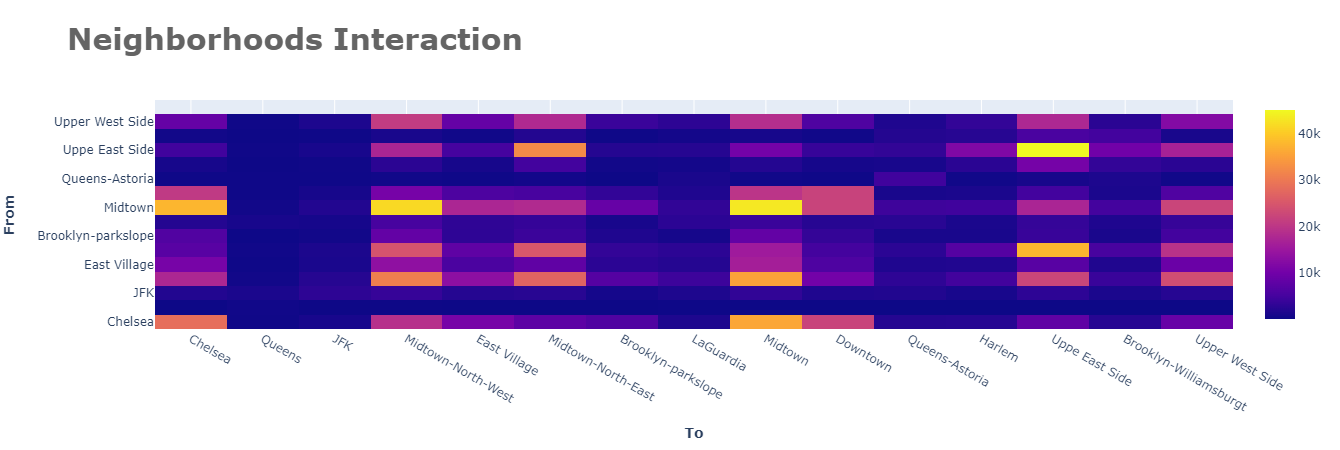

In [54]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

trace = go.Heatmap(z= np.array(rides_df.values),
                  x = rides_df.columns[:-1],
                  y = rides_df.columns)
layout = dict(
    title = ' <b>Neighborhoods Interaction</b>',
    titlefont = dict(
    size = 30,
    color = ('rgb(100,100,100)')),
    margin = dict(t=100,r=100,b=100,l=150),
    yaxis = dict(
        title = ' <b> From </b>'),
    xaxis = dict(
        title = '<b> To </b>')
)
data=[trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

In [55]:
rides_df.index = rides_df.name
rides_df = rides_df.drop('name', axis = 1)

우리는 맨해튼 중심 지역이 가장 많은 택시 승객들로 붐비는 것을 볼 수 있습니다. 그 중에서도 Upper East Side가 가장 많은 승객들을 받고 있습니다. 또한 애니메이션에서는 확인할 수 없지만, 가장 일반적인 승차는 클러스터 내부에서 이루어지는 것을 알 수 있습니다.

열지도는 상당히 대칭적인데, 이는 픽업과 드랍오프 중에서 누가 더 많은 것이나 특별히 두드러지게 차이가 있는 클러스터가 없다는 것을 의미합니다. 이를 좀 더 자세히 살펴보겠습니다.

Text(0.5, 1.0, 'Inbound and Outbound rides for each cluster')

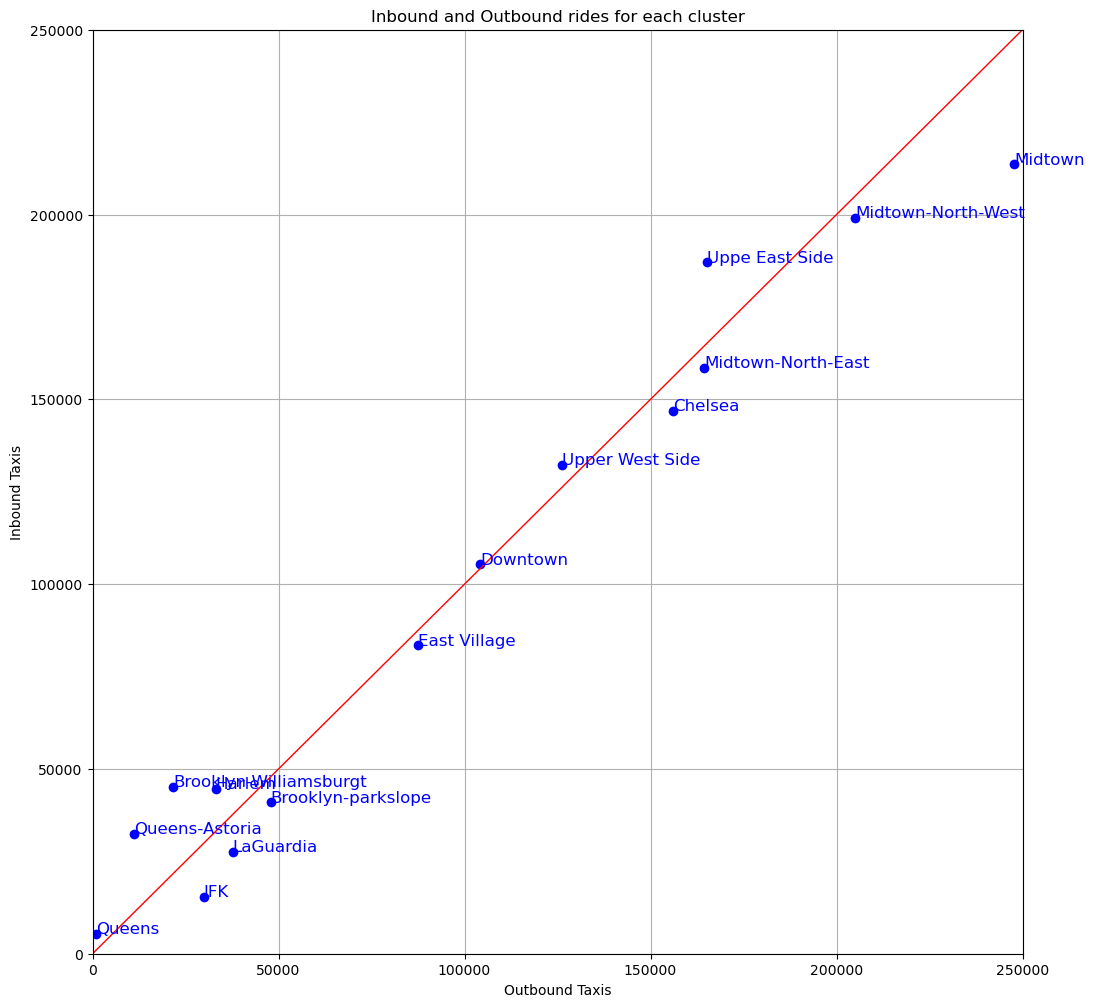

In [56]:
fig,ax = plt.subplots(figsize = (12,12))
for i in range(len(rides_df)):  
    ax.plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax.annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax.plot([0,250000],[0,250000], color = 'r', linewidth = 1)
ax.grid('off')
ax.set_xlim([0,250000])
ax.set_ylim([0,250000])
ax.set_xlabel('Outbound Taxis')
ax.set_ylabel('Inbound Taxis')
ax.set_title('Inbound and Outbound rides for each cluster')

y = x의 직선을 통해서 확인하고자 하는 것

각 지역의 인바운드-아웃바운드 비율이 상대적으로 균형적인 것을 볼 수 있습니다.

두 공항은 인바운드보다 아웃바운드가 더 많으며, 이는 합리적입니다 - 운전자들은 승객 없이도 공항으로 가서 돌아오는 승객을 태우기 위해 출발할 수 있습니다. 주거 지역인 퀸즈, 브루클린 및 하렘은 인바운드 라이드가 더 많고, 상업 및 관광지역은 아웃바운드 라이드가 더 많습니다. 상업 및 주거 모두인 어퍼 이스트 사이드와 웨스트는 거의 곡선 위에 있습니다.

사람들은 대체로 다른 교통 수단으로 맨해튼에 들어가지만, 택시를 이용하여 맨해튼을 떠나는 것이 더 많은 것으로 보입니다.

### Winter vs Summer

In [57]:
df['pickup_month'] = df.pickup_datetime.apply(lambda x: parser.parse(x).month )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



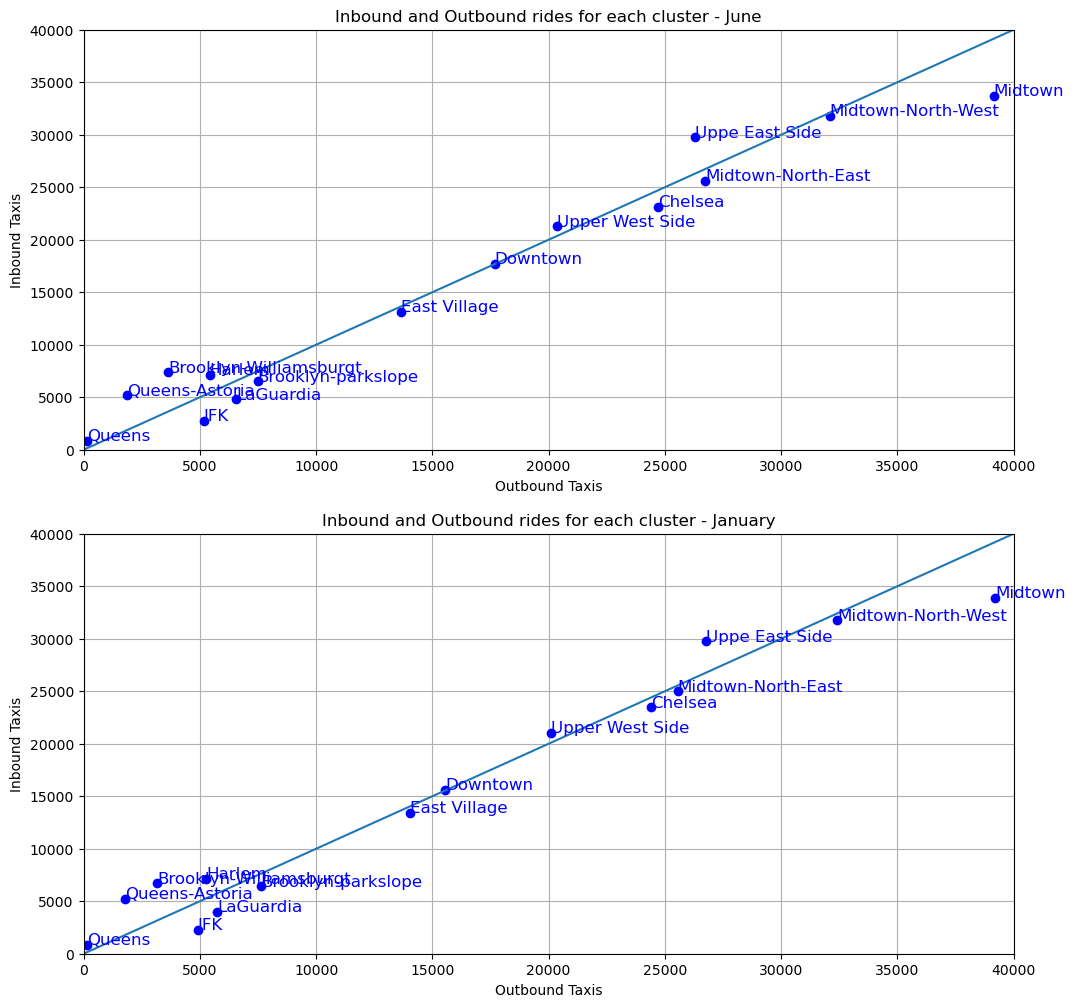

In [58]:
fig,ax = plt.subplots(2,figsize = (12,12))

rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()
rides_df.index = rides_df.name


for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_month == 6)]))
for i in range(len(rides_df)):  
    ax[0].plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax[0].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax[0].grid('off')
ax[0].set_xlabel('Outbound Taxis')
ax[0].set_ylabel('Inbound Taxis')
ax[0].set_title('Inbound and Outbound rides for each cluster - June')
ax[0].set_xlim([0,40000])
ax[0].set_ylim([0,40000])
ax[0].plot([0,40000],[0,40000])


for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_month == 1)]))
rides_df = rides_df.drop('name', axis = 1)
for i in range(len(rides_df)):  
    ax[1].plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax[1].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax[1].grid('off')
ax[1].set_xlabel('Outbound Taxis')
ax[1].set_ylabel('Inbound Taxis')
ax[1].set_title('Inbound and Outbound rides for each cluster - January')
ax[1].set_xlim([0,40000])
ax[1].set_ylim([0,40000])
ax[1].plot([0,40000],[0,40000])

As we can see, the patterns are almost identical regardless of the month. snowy January vs humid and touristic June produce very similar Taxi patterns